[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ilya16/isp-tts/blob/main/notebooks/training.ipynb)

# Setup

Before running the code in Colab: switch the Runtime to GPU

Run two cells below once to download dataset, models and install packages.

In [2]:
import shutil
import os

folder_path = "/content/dataset"

# Удаление папки, если она существует
if os.path.exists(folder_path):
    shutil.rmtree(folder_path)
    print(f"Папка {folder_path} успешно удалена.")
else:
    print(f"Папка {folder_path} не существует.")

Папка /content/dataset успешно удалена.


In [1]:
#@title Download models and code

import os
import IPython.display as ipd

INDEX_ID = "1ejkNbKM5k11ALiXoS_qYbb01O1s2JVpq"
INDEX_FILE = "/content/index.txt"

!gdown {INDEX_ID} -O {INDEX_FILE}

FILE_INDEX = {}
with open(INDEX_FILE, 'r') as f:
    for line in f:
        gid, name = line.strip().split('\t')
        FILE_INDEX[name] = gid

for name, gid in FILE_INDEX.items():
    path = os.path.join("/content", name)
    if not os.path.exists(path):
        !gdown {gid} -O {path}

if os.path.exists("/content/dataset.tar.gz"):
    !tar -xzvf /content/dataset.tar.gz

!git clone https://github.com/ilya16/isp-tts

ipd.clear_output()
print('Successfully downloaded data and code')

Successfully downloaded data and code


In [3]:
#@title Install dependencies
!pip install -r /content/isp-tts/requirements.txt
!apt-get install espeak-ng

ipd.clear_output()
print('Installed required Python libraries')

Installed required Python libraries


# Initialization

Start from here after loading data and installing packages.

In [3]:
#@title Imports
from __future__ import annotations
import os
import sys
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import IPython.display as ipd

CONTENT_DIR = "/content" # @param {type:"string"}

os.chdir(CONTENT_DIR)
sys.path.append(os.path.join(CONTENT_DIR, 'isp-tts'))

os.environ['OMP_NUM_THREADS'] = '1'

import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ipd.clear_output()

# Dataset

The dataset should have the following structure:

```
DATASET_ROOT
  wavs
    audio_1.wav
    audio_2.wav
    ...
    audio_N.wav
  meta.csv
  (meta_train.csv) – can be computed below
  (meta_val.csv) – can be computed below
```

The metadata files should have the following structure:

```
wavs/audio_1.wav|This is the sample text.
wavs/audio_2.wav|The second audio св+язяно с +этим т+екстом.
...
wavs/audio_N.wav|нижний текст.
```

In other words, the metadata files should contain the "|"-separated paths to audios (relative to the dataset root) and matched texts.


In [1]:
#@title Dataset root

#@markdown Change the path to your dataset here
DATASET_ROOT = "/content/dataset" # @param {type:"string"}

## Split metadata into train and validation:

Use the cell below to split your metadata into training and validation sets

In [4]:
#@title Split Data

SPLIT_DATA = True # @param {"type":"boolean"}
META_NAME = "meta.csv" # @param {"type":"string","placeholder":"meta.csv"}
RANDOM_SEED = 42 # @param {"type":"integer"}
VAL_RATIO = 0.1 # @param {"type":"number","placeholder":"0.1"}


def load_meta(filename, split="|"):
    with open(filename, encoding='utf-8') as f:
        meta = [line.strip().split(split) for line in f]
    return meta


def split_meta(meta_name, val_size: float = 0.1, seed: int = 42):
    meta_path = os.path.join(DATASET_ROOT, meta_name)
    meta = load_meta(meta_path)

    ids = np.arange(len(meta))

    np.random.seed(seed)
    np.random.shuffle(ids)
    ids = set(np.sort(ids[:int((1 - val_size) * len(meta))]))

    meta_train = []
    for i, x in enumerate(meta):
        if i in ids:
            meta_train.append(x)

    meta_valid = []
    for i, x in enumerate(meta):
        if i not in ids:
            meta_valid.append(x)

    train_meta_path = os.path.join(DATASET_ROOT, meta_name.replace(".csv", "_train.csv"))
    with open(train_meta_path, "w", encoding="utf-8") as f:
        f.writelines(['|'.join(item) + '\n' for item in meta_train])

    valid_meta_path = os.path.join(DATASET_ROOT, meta_name.replace(".csv", "_valid.csv"))
    with open(valid_meta_path, "w", encoding="utf-8") as f:
        f.writelines(['|'.join(item) + '\n' for item in meta_valid])

    print(f"Split metadata `{meta_path}` ({len(meta)} samples) into:"
          f"\n\ttrain: `{train_meta_path}` ({len(meta_train)} samples)"
          f"\n\tvalid: `{valid_meta_path}` ({len(meta_valid)} samples)")


if SPLIT_DATA:
    split_meta(META_NAME, VAL_RATIO, RANDOM_SEED)

Split metadata `/content/dataset/meta.csv` (35 samples) into:
	train: `/content/dataset/meta_train.csv` (31 samples)
	valid: `/content/dataset/meta_valid.csv` (4 samples)


In [ ]:
r

# Training

The are two options to run the training:
1. directly in the notebook by initializing the model, dataset, and trainer
2. using the `train.py` script


Before the training, you need to complete the training conifguration file. The example files for training in Colab are provided in:
- for training an English-only model: `isp-tts/recipes/colab/train_en_ipa.yaml`
- for training a Russian or multi-language model: `isp-tts/recipes/colab/train_ru_en.yaml`

Modify the following arguments in the selected/copied dataset specific to your data:
```yaml
_general_:
  _dirname_: /content/results  # directory where all logs and checkpoints will be stored
  _label_: voice_ru_en  # name for the experiment
```

```yaml
dataset:
  root: /content/dataset_ars  # path to your dataset

  _train_:
    meta_name: meta_train.csv  # training metadata path relative to the dataset root

  _eval_:
    meta_name: meta_valid.csv  # validation metadata path relative to the dataset root
```

Also, you are free to tune the training parameters in the `trainer` section:
```yaml
trainer:
  epochs: 50
  batch_size: 24  # enough for T4 GPU
  eval_batch_size: 48

  eval_strategy: steps
  eval_steps: 50

  project_name: isp-tts  # wandb project name
  accelerator:
    log_with: [tensorboard]
#    log_with: [wandb, tensorboard]  # change to this to store logs in wandb
```

## Training in the notebook

In [5]:
#@title Initilize Experiment Modules
from tts.experiments.modules import ExperimentModules
from tts.experiments import Trainer

CONFIG_ROOT = "/content/isp-tts/recipes" # @param {"type":"string"}
CONFIG_NAME = "colab/train_ru_en.yaml" # @param {"type":"string"}

exp_modules = ExperimentModules(
    config=CONFIG_NAME,
    config_root=CONFIG_ROOT
)
modules = exp_modules.init_modules()
print(modules.keys())

2025-01-31 02:49:01.764 | DEBUG    | tts.data.dataset:__init__:83 - text_length_limits: 31 samples


  0%|          | 0/31 [00:00<?, ?it/s]

2025-01-31 02:49:01.801 | DEBUG    | tts.data.dataset:__init__:87 - audio_length_limits: 31 samples
2025-01-31 02:49:01.946 | DEBUG    | tts.data.dataset:__init__:83 - text_length_limits: 4 samples


  0%|          | 0/4 [00:00<?, ?it/s]

2025-01-31 02:49:01.965 | DEBUG    | tts.data.dataset:__init__:87 - audio_length_limits: 4 samples
ERROR:numba.cuda.cudadrv.driver:Call to cuLinkAddData results in CUDA_ERROR_UNSUPPORTED_PTX_VERSION


dict_keys(['model', 'criterion', 'train_dataset', 'eval_dataset', 'collator', 'evaluator'])


In [6]:
#@title Inspect the datasets

print(f"Training dataset: {len(modules['train_dataset'])} samples")
print(modules["train_dataset"].meta[:5])
print()
print(f"Validation dataset: {len(modules['eval_dataset'])} samples")
print(modules["eval_dataset"].meta[:5])

Training dataset: 31 samples
[('untitled.wav', 'Всем прив+ет, мен+я зов+ут Арс+ен, +это тест+овая з+апись для TTS. Я б+уду говор+ить как+ой-ли+бо текст, а пот+ом мы провер+им, что с ним произойд+ёт.')
 ('untitled2.wav', 'Я в темнот+е ищ+у отв+еты на вопр+осы о себ+е.')
 ('untitled3.wav', 'Я не смотр+ю на +это ст+адо.')
 ('untitled4.wav', 'Я уч+ился в гимн+азии н+омер семн+адцать.')
 ('untitled - REC_8.wav', 'К+аждый день - канит+ель')]

Validation dataset: 4 samples
[('untitled - REC_11.wav', 'Сейч+ас вр+емя четв+ёртый час н+очи.')
 ('untitled - Track 22.wav', 'Попр+обуй улов+ить мой г+олос, это не так сл+ожно.')
 ('gboe2w4d.wav', 'Я всю жизнь игр+ал на гит+аре')
 ('vgretyka.wav', 'Я всю жизнь игр+ал на гит+аре')]


In [7]:
#@title Initialize the Trainer

trainer = Trainer(
    **modules,
    config=exp_modules.config
)

2025-01-31 02:49:16 INFO    - Initialized output directory: /content/results/AcousticModel/25-01-31/voice_ru_en
2025-01-31 02:49:16 INFO    - Initialized logs directory: /content/results/AcousticModel/25-01-31/voice_ru_en/logs
2025-01-31 02:49:16 INFO    - Built CallbackHandler
2025-01-31 02:49:24 INFO    - Built TrackerCallback
2025-01-31 02:49:24 INFO    - Built Training DataLoader
2025-01-31 02:49:24 INFO    - Built Evaluation DataLoader
2025-01-31 02:49:29 WARNING - The following params are incompatible with the ExponentialLR constructor, so they will be ignored: ['total_steps'].
2025-01-31 02:49:29 INFO    - Built Optimizer
2025-01-31 02:49:29 INFO    - Built Trainer!


In [ ]:
# Uncomment to see the Tensorboard logs in Colab

# %load_ext tensorboard
# %tensorboard --logdir /content/results

In [8]:
#@title Run Training

trainer.train()

2025-01-31 02:49:44 INFO    - *** Loading checkpoint ***
2025-01-31 02:49:44 INFO    - Checkpoint path: `/content/acoustic_ru_en.pt`
2025-01-31 02:49:45 INFO    - Warm start is enabled.
2025-01-31 02:49:45 WARNING - The following checkpoint keys are not presented in the model and will be ignored: ['speaker_embedding.weight']
2025-01-31 02:49:45 INFO    - Automatically found the checkpoint keys incompatible with the model: []
2025-01-31 02:49:45 INFO    - Loaded checkpoint `/content/acoustic_ru_en.pt`.
2025-01-31 02:49:45 INFO    - The model graph has been frozen, except for the following parameters: ['aligner.attention.key_proj.0.conv.weight', 'aligner.attention.key_proj.0.norm.weight', 'aligner.attention.key_proj.0.norm.bias', 'aligner.attention.key_proj.1.conv.weight', 'aligner.attention.query_proj.0.conv.weight', 'aligner.attention.query_proj.0.norm.weight', 'aligner.attention.query_proj.0.norm.bias', 'aligner.attention.query_proj.1.conv.weight', 'aligner.attention.query_proj.1.norm

  0%|          | 0/1 [00:00<?, ?it/s]

2025-01-31 02:49:55 INFO    - [EVAL]  epoch:   0/ 50 (step: 0), loss: 4.80399
2025-01-31 02:49:55 INFO    - {'loss': 4.80399, 'loss/model/mel_loss': 0.93776, 'loss/adaptor/flow_loss': 1.38438, 'loss/aligner/attention_loss': 1.59475, 'loss/aligner/kl_loss': 0.88709, 'metrics/mcd_13': 29.95623, 'metrics/alignment_length': 1.43673, 'metrics/alignment_strength': 0.8274}
2025-01-31 02:49:55 DEBUG   - Set random seed to 23


  0%|          | 0/2 [00:00<?, ?it/s]

2025-01-31 02:49:58 INFO    - [TRAIN] epoch:   1/ 50 (step: 2), loss: 4.19500
2025-01-31 02:49:58 INFO    - {'loss': 4.195, 'loss/model/mel_loss': 1.03144, 'loss/adaptor/flow_loss': 1.01617, 'loss/aligner/attention_loss': 1.45574, 'loss/aligner/kl_loss': 0.69166, 'metrics/mcd_13': 30.75935, 'metrics/alignment_length': 1.78839, 'metrics/alignment_strength': 0.82603}
2025-01-31 02:49:58 DEBUG   - Set random seed to 46


  0%|          | 0/2 [00:00<?, ?it/s]

2025-01-31 02:50:00 INFO    - [TRAIN] epoch:   2/ 50 (step: 4), loss: 4.38082
2025-01-31 02:50:00 INFO    - {'loss': 4.38082, 'loss/model/mel_loss': 0.9507, 'loss/adaptor/flow_loss': 1.08196, 'loss/aligner/attention_loss': 1.54039, 'loss/aligner/kl_loss': 0.80777, 'metrics/mcd_13': 30.04418, 'metrics/alignment_length': 1.79976, 'metrics/alignment_strength': 0.81779}
2025-01-31 02:50:00 DEBUG   - Set random seed to 69


  0%|          | 0/2 [00:00<?, ?it/s]

2025-01-31 02:50:02 INFO    - [TRAIN] epoch:   3/ 50 (step: 6), loss: 4.41480
2025-01-31 02:50:02 INFO    - {'loss': 4.4148, 'loss/model/mel_loss': 1.03755, 'loss/adaptor/flow_loss': 1.12662, 'loss/aligner/attention_loss': 1.49401, 'loss/aligner/kl_loss': 0.75662, 'metrics/mcd_13': 30.58296, 'metrics/alignment_length': 1.76216, 'metrics/alignment_strength': 0.83151}
2025-01-31 02:50:02 DEBUG   - Set random seed to 92


  0%|          | 0/2 [00:00<?, ?it/s]

2025-01-31 02:50:04 INFO    - [TRAIN] epoch:   4/ 50 (step: 8), loss: 4.13908
2025-01-31 02:50:04 INFO    - {'loss': 4.13908, 'loss/model/mel_loss': 0.90969, 'loss/adaptor/flow_loss': 1.20917, 'loss/aligner/attention_loss': 1.41639, 'loss/aligner/kl_loss': 0.60383, 'metrics/mcd_13': 30.12385, 'metrics/alignment_length': 1.78509, 'metrics/alignment_strength': 0.83728}
2025-01-31 02:50:04 DEBUG   - Set random seed to 115


  0%|          | 0/2 [00:00<?, ?it/s]

2025-01-31 02:50:05 INFO    - [TRAIN] epoch:   5/ 50 (step: 10), loss: 4.14637
2025-01-31 02:50:05 INFO    - {'loss': 4.14637, 'loss/model/mel_loss': 0.82302, 'loss/adaptor/flow_loss': 1.00057, 'loss/aligner/attention_loss': 1.49686, 'loss/aligner/kl_loss': 0.82593, 'metrics/mcd_13': 28.73788, 'metrics/alignment_length': 2.01156, 'metrics/alignment_strength': 0.80721}
2025-01-31 02:50:05 DEBUG   - Set random seed to 138


  0%|          | 0/2 [00:00<?, ?it/s]

2025-01-31 02:50:07 INFO    - [TRAIN] epoch:   6/ 50 (step: 12), loss: 4.08103
2025-01-31 02:50:07 INFO    - {'loss': 4.08103, 'loss/model/mel_loss': 0.72281, 'loss/adaptor/flow_loss': 1.14719, 'loss/aligner/attention_loss': 1.49636, 'loss/aligner/kl_loss': 0.71467, 'metrics/mcd_13': 27.60899, 'metrics/alignment_length': 1.79483, 'metrics/alignment_strength': 0.82614}
2025-01-31 02:50:07 DEBUG   - Set random seed to 161


  0%|          | 0/2 [00:00<?, ?it/s]

2025-01-31 02:50:08 INFO    - [TRAIN] epoch:   7/ 50 (step: 14), loss: 3.77793
2025-01-31 02:50:08 INFO    - {'loss': 3.77793, 'loss/model/mel_loss': 0.56935, 'loss/adaptor/flow_loss': 1.01489, 'loss/aligner/attention_loss': 1.45041, 'loss/aligner/kl_loss': 0.74328, 'metrics/mcd_13': 25.1334, 'metrics/alignment_length': 1.71372, 'metrics/alignment_strength': 0.82607}
2025-01-31 02:50:08 DEBUG   - Set random seed to 184


  0%|          | 0/2 [00:00<?, ?it/s]

2025-01-31 02:50:10 INFO    - [TRAIN] epoch:   8/ 50 (step: 16), loss: 3.44516
2025-01-31 02:50:10 INFO    - {'loss': 3.44516, 'loss/model/mel_loss': 0.5527, 'loss/adaptor/flow_loss': 0.92008, 'loss/aligner/attention_loss': 1.40232, 'loss/aligner/kl_loss': 0.57006, 'metrics/mcd_13': 24.3702, 'metrics/alignment_length': 1.70322, 'metrics/alignment_strength': 0.84917}
2025-01-31 02:50:10 DEBUG   - Set random seed to 207


  0%|          | 0/2 [00:00<?, ?it/s]

2025-01-31 02:50:12 INFO    - [TRAIN] epoch:   9/ 50 (step: 18), loss: 3.37458
2025-01-31 02:50:12 INFO    - {'loss': 3.37458, 'loss/model/mel_loss': 0.52297, 'loss/adaptor/flow_loss': 0.90119, 'loss/aligner/attention_loss': 1.39016, 'loss/aligner/kl_loss': 0.56026, 'metrics/mcd_13': 23.60524, 'metrics/alignment_length': 1.62364, 'metrics/alignment_strength': 0.85064}
2025-01-31 02:50:12 DEBUG   - Set random seed to 230


  0%|          | 0/2 [00:00<?, ?it/s]

2025-01-31 02:50:14 INFO    - [TRAIN] epoch:  10/ 50 (step: 20), loss: 3.39098
2025-01-31 02:50:14 INFO    - {'loss': 3.39098, 'loss/model/mel_loss': 0.46792, 'loss/adaptor/flow_loss': 0.83088, 'loss/aligner/attention_loss': 1.45199, 'loss/aligner/kl_loss': 0.64018, 'metrics/mcd_13': 22.15272, 'metrics/alignment_length': 1.76238, 'metrics/alignment_strength': 0.8371}
2025-01-31 02:50:14 DEBUG   - Set random seed to 253


  0%|          | 0/2 [00:00<?, ?it/s]

2025-01-31 02:50:16 INFO    - [TRAIN] epoch:  11/ 50 (step: 22), loss: 3.52476
2025-01-31 02:50:16 INFO    - {'loss': 3.52476, 'loss/model/mel_loss': 0.4722, 'loss/adaptor/flow_loss': 0.84843, 'loss/aligner/attention_loss': 1.53012, 'loss/aligner/kl_loss': 0.674, 'metrics/mcd_13': 21.74284, 'metrics/alignment_length': 1.92711, 'metrics/alignment_strength': 0.81419}
2025-01-31 02:50:16 DEBUG   - Set random seed to 276


  0%|          | 0/2 [00:00<?, ?it/s]

2025-01-31 02:50:17 INFO    - [TRAIN] epoch:  12/ 50 (step: 24), loss: 3.40284
2025-01-31 02:50:17 INFO    - {'loss': 3.40284, 'loss/model/mel_loss': 0.44206, 'loss/adaptor/flow_loss': 0.935, 'loss/aligner/attention_loss': 1.36276, 'loss/aligner/kl_loss': 0.66301, 'metrics/mcd_13': 21.66706, 'metrics/alignment_length': 1.79174, 'metrics/alignment_strength': 0.82827}
2025-01-31 02:50:17 DEBUG   - Set random seed to 299


  0%|          | 0/2 [00:00<?, ?it/s]

2025-01-31 02:50:18 INFO    - [TRAIN] epoch:  13/ 50 (step: 26), loss: 3.58644
2025-01-31 02:50:18 INFO    - {'loss': 3.58644, 'loss/model/mel_loss': 0.43757, 'loss/adaptor/flow_loss': 0.88099, 'loss/aligner/attention_loss': 1.55422, 'loss/aligner/kl_loss': 0.71366, 'metrics/mcd_13': 20.60037, 'metrics/alignment_length': 1.81944, 'metrics/alignment_strength': 0.81945}
2025-01-31 02:50:18 DEBUG   - Set random seed to 322


  0%|          | 0/2 [00:00<?, ?it/s]

2025-01-31 02:50:20 INFO    - [TRAIN] epoch:  14/ 50 (step: 28), loss: 3.37707
2025-01-31 02:50:20 INFO    - {'loss': 3.37707, 'loss/model/mel_loss': 0.42466, 'loss/adaptor/flow_loss': 0.88658, 'loss/aligner/attention_loss': 1.41232, 'loss/aligner/kl_loss': 0.65351, 'metrics/mcd_13': 20.59412, 'metrics/alignment_length': 1.58838, 'metrics/alignment_strength': 0.84402}
2025-01-31 02:50:20 DEBUG   - Set random seed to 345


  0%|          | 0/2 [00:00<?, ?it/s]

2025-01-31 02:50:22 INFO    - [TRAIN] epoch:  15/ 50 (step: 30), loss: 3.06704
2025-01-31 02:50:22 INFO    - {'loss': 3.06704, 'loss/model/mel_loss': 0.41065, 'loss/adaptor/flow_loss': 0.79323, 'loss/aligner/attention_loss': 1.36574, 'loss/aligner/kl_loss': 0.49742, 'metrics/mcd_13': 20.13773, 'metrics/alignment_length': 1.62221, 'metrics/alignment_strength': 0.84798}
2025-01-31 02:50:22 DEBUG   - Set random seed to 368


  0%|          | 0/2 [00:00<?, ?it/s]

2025-01-31 02:50:23 INFO    - [TRAIN] epoch:  16/ 50 (step: 32), loss: 3.30587
2025-01-31 02:50:23 INFO    - {'loss': 3.30587, 'loss/model/mel_loss': 0.46229, 'loss/adaptor/flow_loss': 0.75391, 'loss/aligner/attention_loss': 1.46184, 'loss/aligner/kl_loss': 0.62783, 'metrics/mcd_13': 20.10665, 'metrics/alignment_length': 1.75137, 'metrics/alignment_strength': 0.83297}
2025-01-31 02:50:23 DEBUG   - Set random seed to 391


  0%|          | 0/2 [00:00<?, ?it/s]

2025-01-31 02:50:25 INFO    - [TRAIN] epoch:  17/ 50 (step: 34), loss: 3.19091
2025-01-31 02:50:25 INFO    - {'loss': 3.19091, 'loss/model/mel_loss': 0.38964, 'loss/adaptor/flow_loss': 0.7748, 'loss/aligner/attention_loss': 1.44414, 'loss/aligner/kl_loss': 0.58234, 'metrics/mcd_13': 19.8413, 'metrics/alignment_length': 1.57666, 'metrics/alignment_strength': 0.84715}
2025-01-31 02:50:25 DEBUG   - Set random seed to 414


  0%|          | 0/2 [00:00<?, ?it/s]

2025-01-31 02:50:27 INFO    - [TRAIN] epoch:  18/ 50 (step: 36), loss: 3.01527
2025-01-31 02:50:27 INFO    - {'loss': 3.01527, 'loss/model/mel_loss': 0.40288, 'loss/adaptor/flow_loss': 0.79396, 'loss/aligner/attention_loss': 1.33301, 'loss/aligner/kl_loss': 0.48541, 'metrics/mcd_13': 19.98819, 'metrics/alignment_length': 1.59897, 'metrics/alignment_strength': 0.8546}
2025-01-31 02:50:27 DEBUG   - Set random seed to 437


  0%|          | 0/2 [00:00<?, ?it/s]

2025-01-31 02:50:29 INFO    - [TRAIN] epoch:  19/ 50 (step: 38), loss: 3.16221
2025-01-31 02:50:29 INFO    - {'loss': 3.16221, 'loss/model/mel_loss': 0.38528, 'loss/adaptor/flow_loss': 0.76676, 'loss/aligner/attention_loss': 1.38982, 'loss/aligner/kl_loss': 0.62035, 'metrics/mcd_13': 19.1846, 'metrics/alignment_length': 1.65867, 'metrics/alignment_strength': 0.83377}
2025-01-31 02:50:29 DEBUG   - Set random seed to 460


  0%|          | 0/2 [00:00<?, ?it/s]

2025-01-31 02:50:31 INFO    - [TRAIN] epoch:  20/ 50 (step: 40), loss: 3.04795
2025-01-31 02:50:31 INFO    - {'loss': 3.04795, 'loss/model/mel_loss': 0.39419, 'loss/adaptor/flow_loss': 0.72926, 'loss/aligner/attention_loss': 1.36704, 'loss/aligner/kl_loss': 0.55747, 'metrics/mcd_13': 19.63301, 'metrics/alignment_length': 1.65805, 'metrics/alignment_strength': 0.84583}
2025-01-31 02:50:31 DEBUG   - Set random seed to 483


  0%|          | 0/2 [00:00<?, ?it/s]

2025-01-31 02:50:33 INFO    - [TRAIN] epoch:  21/ 50 (step: 42), loss: 3.12912
2025-01-31 02:50:33 INFO    - {'loss': 3.12912, 'loss/model/mel_loss': 0.42088, 'loss/adaptor/flow_loss': 0.70336, 'loss/aligner/attention_loss': 1.46131, 'loss/aligner/kl_loss': 0.54358, 'metrics/mcd_13': 18.8615, 'metrics/alignment_length': 1.6472, 'metrics/alignment_strength': 0.85045}
2025-01-31 02:50:33 DEBUG   - Set random seed to 506


  0%|          | 0/2 [00:00<?, ?it/s]

2025-01-31 02:50:34 INFO    - [TRAIN] epoch:  22/ 50 (step: 44), loss: 2.80986
2025-01-31 02:50:34 INFO    - {'loss': 2.80986, 'loss/model/mel_loss': 0.37924, 'loss/adaptor/flow_loss': 0.70062, 'loss/aligner/attention_loss': 1.29951, 'loss/aligner/kl_loss': 0.43049, 'metrics/mcd_13': 19.15763, 'metrics/alignment_length': 1.61189, 'metrics/alignment_strength': 0.86076}
2025-01-31 02:50:34 DEBUG   - Set random seed to 529


  0%|          | 0/2 [00:00<?, ?it/s]

2025-01-31 02:50:36 INFO    - [TRAIN] epoch:  23/ 50 (step: 46), loss: 2.93007
2025-01-31 02:50:36 INFO    - {'loss': 2.93007, 'loss/model/mel_loss': 0.38813, 'loss/adaptor/flow_loss': 0.76276, 'loss/aligner/attention_loss': 1.30858, 'loss/aligner/kl_loss': 0.4706, 'metrics/mcd_13': 19.15233, 'metrics/alignment_length': 1.56803, 'metrics/alignment_strength': 0.85947}
2025-01-31 02:50:36 DEBUG   - Set random seed to 552


  0%|          | 0/2 [00:00<?, ?it/s]

2025-01-31 02:50:38 INFO    - [TRAIN] epoch:  24/ 50 (step: 48), loss: 2.98642
2025-01-31 02:50:38 INFO    - {'loss': 2.98642, 'loss/model/mel_loss': 0.36689, 'loss/adaptor/flow_loss': 0.79871, 'loss/aligner/attention_loss': 1.38047, 'loss/aligner/kl_loss': 0.44036, 'metrics/mcd_13': 18.1257, 'metrics/alignment_length': 1.58654, 'metrics/alignment_strength': 0.86113}
2025-01-31 02:50:38 DEBUG   - Set random seed to 575


  0%|          | 0/2 [00:00<?, ?it/s]

2025-01-31 02:50:40 INFO    - *** Running evaluation ***


  0%|          | 0/1 [00:00<?, ?it/s]

2025-01-31 02:50:42 INFO    - [EVAL]  epoch:  25/ 50 (step: 50), loss: 3.57415
2025-01-31 02:50:42 INFO    - {'loss': 3.57415, 'loss/model/mel_loss': 0.4719, 'loss/adaptor/flow_loss': 0.73258, 'loss/aligner/attention_loss': 1.4882, 'loss/aligner/kl_loss': 0.88147, 'metrics/mcd_13': 19.426, 'metrics/alignment_length': 1.29584, 'metrics/alignment_strength': 0.8619}
2025-01-31 02:50:42 INFO    - Metric improvement on evaluation set (loss: 3.57415)
2025-01-31 02:50:42 INFO    - *** Saving checkpoint /content/results/AcousticModel/25-01-31/voice_ru_en/checkpoint_s50.pt ***
2025-01-31 02:50:42 INFO    - [TRAIN] epoch:  25/ 50 (step: 50), loss: 2.86708
2025-01-31 02:50:42 INFO    - {'loss': 2.86708, 'loss/model/mel_loss': 0.37276, 'loss/adaptor/flow_loss': 0.70501, 'loss/aligner/attention_loss': 1.35666, 'loss/aligner/kl_loss': 0.43265, 'metrics/mcd_13': 18.62173, 'metrics/alignment_length': 1.56459, 'metrics/alignment_strength': 0.85538}
2025-01-31 02:50:42 DEBUG   - Set random seed to 598


  0%|          | 0/2 [00:00<?, ?it/s]

2025-01-31 02:50:44 INFO    - [TRAIN] epoch:  26/ 50 (step: 52), loss: 3.05151
2025-01-31 02:50:44 INFO    - {'loss': 3.05151, 'loss/model/mel_loss': 0.36764, 'loss/adaptor/flow_loss': 0.65486, 'loss/aligner/attention_loss': 1.50377, 'loss/aligner/kl_loss': 0.52524, 'metrics/mcd_13': 18.27402, 'metrics/alignment_length': 1.65053, 'metrics/alignment_strength': 0.84795}
2025-01-31 02:50:44 DEBUG   - Set random seed to 621


  0%|          | 0/2 [00:00<?, ?it/s]

2025-01-31 02:50:46 INFO    - [TRAIN] epoch:  27/ 50 (step: 54), loss: 2.85681
2025-01-31 02:50:46 INFO    - {'loss': 2.85681, 'loss/model/mel_loss': 0.37158, 'loss/adaptor/flow_loss': 0.70627, 'loss/aligner/attention_loss': 1.3273, 'loss/aligner/kl_loss': 0.45166, 'metrics/mcd_13': 18.65681, 'metrics/alignment_length': 1.56161, 'metrics/alignment_strength': 0.85286}
2025-01-31 02:50:46 DEBUG   - Set random seed to 644


  0%|          | 0/2 [00:00<?, ?it/s]

2025-01-31 02:50:48 INFO    - [TRAIN] epoch:  28/ 50 (step: 56), loss: 2.96542
2025-01-31 02:50:48 INFO    - {'loss': 2.96542, 'loss/model/mel_loss': 0.39131, 'loss/adaptor/flow_loss': 0.72123, 'loss/aligner/attention_loss': 1.33846, 'loss/aligner/kl_loss': 0.51443, 'metrics/mcd_13': 18.43028, 'metrics/alignment_length': 1.59358, 'metrics/alignment_strength': 0.85131}
2025-01-31 02:50:48 DEBUG   - Set random seed to 667


  0%|          | 0/2 [00:00<?, ?it/s]

2025-01-31 02:50:49 INFO    - [TRAIN] epoch:  29/ 50 (step: 58), loss: 2.96802
2025-01-31 02:50:49 INFO    - {'loss': 2.96802, 'loss/model/mel_loss': 0.35315, 'loss/adaptor/flow_loss': 0.64887, 'loss/aligner/attention_loss': 1.43161, 'loss/aligner/kl_loss': 0.53438, 'metrics/mcd_13': 18.02044, 'metrics/alignment_length': 1.8368, 'metrics/alignment_strength': 0.8287}
2025-01-31 02:50:49 DEBUG   - Set random seed to 690


  0%|          | 0/2 [00:00<?, ?it/s]

2025-01-31 02:50:51 INFO    - [TRAIN] epoch:  30/ 50 (step: 60), loss: 2.92608
2025-01-31 02:50:51 INFO    - {'loss': 2.92608, 'loss/model/mel_loss': 0.33679, 'loss/adaptor/flow_loss': 0.7318, 'loss/aligner/attention_loss': 1.36254, 'loss/aligner/kl_loss': 0.49495, 'metrics/mcd_13': 17.66414, 'metrics/alignment_length': 1.50936, 'metrics/alignment_strength': 0.85858}
2025-01-31 02:50:51 DEBUG   - Set random seed to 713


  0%|          | 0/2 [00:00<?, ?it/s]

2025-01-31 02:50:52 INFO    - [TRAIN] epoch:  31/ 50 (step: 62), loss: 2.62629
2025-01-31 02:50:52 INFO    - {'loss': 2.62629, 'loss/model/mel_loss': 0.34538, 'loss/adaptor/flow_loss': 0.69709, 'loss/aligner/attention_loss': 1.22198, 'loss/aligner/kl_loss': 0.36184, 'metrics/mcd_13': 18.14781, 'metrics/alignment_length': 1.48945, 'metrics/alignment_strength': 0.87046}
2025-01-31 02:50:52 DEBUG   - Set random seed to 736


  0%|          | 0/2 [00:00<?, ?it/s]

2025-01-31 02:50:55 INFO    - [TRAIN] epoch:  32/ 50 (step: 64), loss: 3.02495
2025-01-31 02:50:55 INFO    - {'loss': 3.02495, 'loss/model/mel_loss': 0.35458, 'loss/adaptor/flow_loss': 0.81959, 'loss/aligner/attention_loss': 1.40295, 'loss/aligner/kl_loss': 0.44783, 'metrics/mcd_13': 17.82539, 'metrics/alignment_length': 1.61422, 'metrics/alignment_strength': 0.85396}
2025-01-31 02:50:55 DEBUG   - Set random seed to 759


  0%|          | 0/2 [00:00<?, ?it/s]

2025-01-31 02:50:56 INFO    - [TRAIN] epoch:  33/ 50 (step: 66), loss: 3.17185
2025-01-31 02:50:56 INFO    - {'loss': 3.17185, 'loss/model/mel_loss': 0.35226, 'loss/adaptor/flow_loss': 0.72191, 'loss/aligner/attention_loss': 1.46853, 'loss/aligner/kl_loss': 0.62916, 'metrics/mcd_13': 17.65042, 'metrics/alignment_length': 1.67487, 'metrics/alignment_strength': 0.82817}
2025-01-31 02:50:57 DEBUG   - Set random seed to 782


  0%|          | 0/2 [00:00<?, ?it/s]

2025-01-31 02:50:58 INFO    - [TRAIN] epoch:  34/ 50 (step: 68), loss: 3.05658
2025-01-31 02:50:58 INFO    - {'loss': 3.05658, 'loss/model/mel_loss': 0.35747, 'loss/adaptor/flow_loss': 0.74147, 'loss/aligner/attention_loss': 1.43438, 'loss/aligner/kl_loss': 0.52326, 'metrics/mcd_13': 18.16996, 'metrics/alignment_length': 1.72056, 'metrics/alignment_strength': 0.83303}
2025-01-31 02:50:58 DEBUG   - Set random seed to 805


  0%|          | 0/2 [00:00<?, ?it/s]

2025-01-31 02:51:00 INFO    - [TRAIN] epoch:  35/ 50 (step: 70), loss: 2.91581
2025-01-31 02:51:00 INFO    - {'loss': 2.91581, 'loss/model/mel_loss': 0.37078, 'loss/adaptor/flow_loss': 0.76591, 'loss/aligner/attention_loss': 1.35221, 'loss/aligner/kl_loss': 0.42691, 'metrics/mcd_13': 18.17613, 'metrics/alignment_length': 1.56678, 'metrics/alignment_strength': 0.85921}
2025-01-31 02:51:00 DEBUG   - Set random seed to 828


  0%|          | 0/2 [00:00<?, ?it/s]

2025-01-31 02:51:01 INFO    - [TRAIN] epoch:  36/ 50 (step: 72), loss: 2.91829
2025-01-31 02:51:01 INFO    - {'loss': 2.91829, 'loss/model/mel_loss': 0.35176, 'loss/adaptor/flow_loss': 0.79987, 'loss/aligner/attention_loss': 1.34738, 'loss/aligner/kl_loss': 0.41927, 'metrics/mcd_13': 17.84696, 'metrics/alignment_length': 1.57299, 'metrics/alignment_strength': 0.85566}
2025-01-31 02:51:01 DEBUG   - Set random seed to 851


  0%|          | 0/2 [00:00<?, ?it/s]

2025-01-31 02:51:03 INFO    - [TRAIN] epoch:  37/ 50 (step: 74), loss: 2.85472
2025-01-31 02:51:03 INFO    - {'loss': 2.85472, 'loss/model/mel_loss': 0.33626, 'loss/adaptor/flow_loss': 0.66875, 'loss/aligner/attention_loss': 1.35752, 'loss/aligner/kl_loss': 0.49219, 'metrics/mcd_13': 17.57458, 'metrics/alignment_length': 1.58469, 'metrics/alignment_strength': 0.85191}
2025-01-31 02:51:03 DEBUG   - Set random seed to 874


  0%|          | 0/2 [00:00<?, ?it/s]

2025-01-31 02:51:05 INFO    - [TRAIN] epoch:  38/ 50 (step: 76), loss: 2.87686
2025-01-31 02:51:05 INFO    - {'loss': 2.87686, 'loss/model/mel_loss': 0.33008, 'loss/adaptor/flow_loss': 0.74285, 'loss/aligner/attention_loss': 1.33433, 'loss/aligner/kl_loss': 0.46961, 'metrics/mcd_13': 17.51836, 'metrics/alignment_length': 1.6223, 'metrics/alignment_strength': 0.85366}
2025-01-31 02:51:05 DEBUG   - Set random seed to 897


  0%|          | 0/2 [00:00<?, ?it/s]

2025-01-31 02:51:07 INFO    - [TRAIN] epoch:  39/ 50 (step: 78), loss: 2.64085
2025-01-31 02:51:07 INFO    - {'loss': 2.64085, 'loss/model/mel_loss': 0.34153, 'loss/adaptor/flow_loss': 0.58376, 'loss/aligner/attention_loss': 1.23922, 'loss/aligner/kl_loss': 0.47634, 'metrics/mcd_13': 17.98772, 'metrics/alignment_length': 1.48634, 'metrics/alignment_strength': 0.84541}
2025-01-31 02:51:07 DEBUG   - Set random seed to 920


  0%|          | 0/2 [00:00<?, ?it/s]

2025-01-31 02:51:09 INFO    - [TRAIN] epoch:  40/ 50 (step: 80), loss: 2.98041
2025-01-31 02:51:09 INFO    - {'loss': 2.98041, 'loss/model/mel_loss': 0.34015, 'loss/adaptor/flow_loss': 0.74859, 'loss/aligner/attention_loss': 1.36048, 'loss/aligner/kl_loss': 0.5312, 'metrics/mcd_13': 17.61802, 'metrics/alignment_length': 1.63406, 'metrics/alignment_strength': 0.84687}
2025-01-31 02:51:09 DEBUG   - Set random seed to 943


  0%|          | 0/2 [00:00<?, ?it/s]

2025-01-31 02:51:11 INFO    - [TRAIN] epoch:  41/ 50 (step: 82), loss: 2.61115
2025-01-31 02:51:11 INFO    - {'loss': 2.61115, 'loss/model/mel_loss': 0.33273, 'loss/adaptor/flow_loss': 0.62014, 'loss/aligner/attention_loss': 1.29327, 'loss/aligner/kl_loss': 0.36501, 'metrics/mcd_13': 17.51486, 'metrics/alignment_length': 1.49903, 'metrics/alignment_strength': 0.86919}
2025-01-31 02:51:11 DEBUG   - Set random seed to 966


  0%|          | 0/2 [00:00<?, ?it/s]

2025-01-31 02:51:13 INFO    - [TRAIN] epoch:  42/ 50 (step: 84), loss: 2.88782
2025-01-31 02:51:13 INFO    - {'loss': 2.88782, 'loss/model/mel_loss': 0.32389, 'loss/adaptor/flow_loss': 0.66543, 'loss/aligner/attention_loss': 1.3765, 'loss/aligner/kl_loss': 0.52201, 'metrics/mcd_13': 17.14046, 'metrics/alignment_length': 1.54308, 'metrics/alignment_strength': 0.84714}
2025-01-31 02:51:13 DEBUG   - Set random seed to 989


  0%|          | 0/2 [00:00<?, ?it/s]

2025-01-31 02:51:14 INFO    - [TRAIN] epoch:  43/ 50 (step: 86), loss: 2.87146
2025-01-31 02:51:14 INFO    - {'loss': 2.87146, 'loss/model/mel_loss': 0.30124, 'loss/adaptor/flow_loss': 0.73774, 'loss/aligner/attention_loss': 1.3598, 'loss/aligner/kl_loss': 0.47268, 'metrics/mcd_13': 16.67598, 'metrics/alignment_length': 1.54029, 'metrics/alignment_strength': 0.85548}
2025-01-31 02:51:14 DEBUG   - Set random seed to 1012


  0%|          | 0/2 [00:00<?, ?it/s]

2025-01-31 02:51:16 INFO    - [TRAIN] epoch:  44/ 50 (step: 88), loss: 2.72119
2025-01-31 02:51:16 INFO    - {'loss': 2.72119, 'loss/model/mel_loss': 0.31156, 'loss/adaptor/flow_loss': 0.74085, 'loss/aligner/attention_loss': 1.29897, 'loss/aligner/kl_loss': 0.36981, 'metrics/mcd_13': 16.94087, 'metrics/alignment_length': 1.46149, 'metrics/alignment_strength': 0.86665}
2025-01-31 02:51:16 DEBUG   - Set random seed to 1035


  0%|          | 0/2 [00:00<?, ?it/s]

2025-01-31 02:51:18 INFO    - [TRAIN] epoch:  45/ 50 (step: 90), loss: 2.74855
2025-01-31 02:51:18 INFO    - {'loss': 2.74855, 'loss/model/mel_loss': 0.32565, 'loss/adaptor/flow_loss': 0.72393, 'loss/aligner/attention_loss': 1.33579, 'loss/aligner/kl_loss': 0.36318, 'metrics/mcd_13': 17.32206, 'metrics/alignment_length': 1.54313, 'metrics/alignment_strength': 0.85808}
2025-01-31 02:51:18 DEBUG   - Set random seed to 1058


  0%|          | 0/2 [00:00<?, ?it/s]

2025-01-31 02:51:20 INFO    - [TRAIN] epoch:  46/ 50 (step: 92), loss: 2.61813
2025-01-31 02:51:20 INFO    - {'loss': 2.61813, 'loss/model/mel_loss': 0.32775, 'loss/adaptor/flow_loss': 0.68336, 'loss/aligner/attention_loss': 1.26785, 'loss/aligner/kl_loss': 0.33917, 'metrics/mcd_13': 17.37446, 'metrics/alignment_length': 1.4799, 'metrics/alignment_strength': 0.86782}
2025-01-31 02:51:20 DEBUG   - Set random seed to 1081


  0%|          | 0/2 [00:00<?, ?it/s]

2025-01-31 02:51:21 INFO    - [TRAIN] epoch:  47/ 50 (step: 94), loss: 2.72297
2025-01-31 02:51:21 INFO    - {'loss': 2.72297, 'loss/model/mel_loss': 0.3182, 'loss/adaptor/flow_loss': 0.64993, 'loss/aligner/attention_loss': 1.2966, 'loss/aligner/kl_loss': 0.45824, 'metrics/mcd_13': 17.05873, 'metrics/alignment_length': 1.62693, 'metrics/alignment_strength': 0.84494}
2025-01-31 02:51:22 DEBUG   - Set random seed to 1104


  0%|          | 0/2 [00:00<?, ?it/s]

2025-01-31 02:51:23 INFO    - [TRAIN] epoch:  48/ 50 (step: 96), loss: 2.64011
2025-01-31 02:51:23 INFO    - {'loss': 2.64011, 'loss/model/mel_loss': 0.31509, 'loss/adaptor/flow_loss': 0.63614, 'loss/aligner/attention_loss': 1.29924, 'loss/aligner/kl_loss': 0.38963, 'metrics/mcd_13': 17.04958, 'metrics/alignment_length': 1.54472, 'metrics/alignment_strength': 0.86225}
2025-01-31 02:51:24 DEBUG   - Set random seed to 1127


  0%|          | 0/2 [00:00<?, ?it/s]

2025-01-31 02:51:25 INFO    - [TRAIN] epoch:  49/ 50 (step: 98), loss: 2.82171
2025-01-31 02:51:25 INFO    - {'loss': 2.82171, 'loss/model/mel_loss': 0.32697, 'loss/adaptor/flow_loss': 0.63554, 'loss/aligner/attention_loss': 1.39702, 'loss/aligner/kl_loss': 0.46219, 'metrics/mcd_13': 17.24366, 'metrics/alignment_length': 1.68483, 'metrics/alignment_strength': 0.82708}
2025-01-31 02:51:25 DEBUG   - Set random seed to 1150


  0%|          | 0/2 [00:00<?, ?it/s]

2025-01-31 02:51:27 INFO    - *** Running evaluation ***


  0%|          | 0/1 [00:00<?, ?it/s]

2025-01-31 02:51:28 INFO    - [EVAL]  epoch:  50/ 50 (step: 100), loss: 3.44543
2025-01-31 02:51:28 INFO    - {'loss': 3.44543, 'loss/model/mel_loss': 0.40923, 'loss/adaptor/flow_loss': 0.65929, 'loss/aligner/attention_loss': 1.48252, 'loss/aligner/kl_loss': 0.89438, 'metrics/mcd_13': 18.53187, 'metrics/alignment_length': 1.37316, 'metrics/alignment_strength': 0.85916}
2025-01-31 02:51:28 INFO    - Metric improvement on evaluation set (loss: 3.57415 -> 3.44543)
2025-01-31 02:51:28 INFO    - *** Saving checkpoint /content/results/AcousticModel/25-01-31/voice_ru_en/checkpoint_s100.pt ***
2025-01-31 02:51:28 INFO    - [TRAIN] epoch:  50/ 50 (step: 100), loss: 2.69250
2025-01-31 02:51:28 INFO    - {'loss': 2.6925, 'loss/model/mel_loss': 0.33198, 'loss/adaptor/flow_loss': 0.7589, 'loss/aligner/attention_loss': 1.24012, 'loss/aligner/kl_loss': 0.3615, 'metrics/mcd_13': 17.64458, 'metrics/alignment_length': 1.48162, 'metrics/alignment_strength': 0.86327}
2025-01-31 02:51:28 INFO    - *** Savi

## Script-based Training

The same logic is implemented inside the `train.py` script.

In [ ]:
# Uncomment to run the training

# import os
# os.chdir("/content/isp-tts")

# !PYTHONPATH=. OMP_NUM_THREADS=1 python3 tts/train.py --config-root {CONFIG_ROOT} --config-name {CONFIG_NAME}

# Inference

Don't forget to save the model checkpoints locally or on Google Drive after training the model!

You can the trained model below. Specify the model path in `ACOUSTIC_MODEL_PATH` and load the pre-trained Vocoder and Text Provider

In [9]:
#@title Load Acoustic Model
from omegaconf import OmegaConf
from tts.data.providers import TextProvider
from tts.models import AcousticModel
from tts.utils import count_parameters

SAMPLE_RATE = 22050

ACOUSTIC_MODEL_PATH = "/content/results/AcousticModel/25-01-31/voice_ru_en/checkpoint_last.pt" # @param {"type":"string"}

model = AcousticModel.from_pretrained(ACOUSTIC_MODEL_PATH)
model.eval()
model = model.to(device)

print(f'Built AcousticModel `{ACOUSTIC_MODEL_PATH}` with {count_parameters(model)} parameters')

ERROR:numba.cuda.cudadrv.driver:Call to cuLinkAddData results in CUDA_ERROR_UNSUPPORTED_PTX_VERSION


Built AcousticModel `/content/results/AcousticModel/25-01-31/voice_ru_en/checkpoint_last.pt` with 23136747 parameters


In [10]:
#@title Build Vocoder Model



charset = ['<pad>', '</s>', '#punct', '#en', '#ipa_ph']
charset = ['<pad>', '</s>', '#punct', '#marks', '#ru', '#en']

text_provider = TextProvider(
    charset=charset,
    phonemizer='#ipa_ph' in charset,
    mask_phonemes=False
)

text_provider.coding_table
VOCODER = "vocos_ms_fp16" #@param ["vocos_ms_fp16"] {allow-input: false}
VOCODER_PATH = f'/content/{VOCODER}.pts'

vocoder_path = "/content/vocos_ms_fp16.pts"
vocoder = torch.jit.load(vocoder_path, map_location='cpu')
vocoder = vocoder.eval().to(device)

print(f'Built Vocoder `{VOCODER}` with {count_parameters(vocoder)} parameters')

Built Vocoder `vocos_ms_fp16` with 13454850 parameters


In [45]:
#@title Build Text Provider

if "ё" in model.encoding_map:  # a simple check for Russian symbols
    charset = ['<pad>', '</s>', '#punct', '#marks', '#ru', '#en']
else:
    charset = ['<pad>', '</s>', '#punct', '#en', '#ipa_ph']

text_provider = TextProvider(
    charset=charset,
    phonemizer='#ipa_ph' in charset,
    mask_phonemes=False
)
print(f'Built TextProvider with symbols: `{text_provider.coding_table}`')


Built TextProvider with symbols: `<pad> </s> . ! ? ( ) : ; , — -   ' " + * \ а б в г д е ё ж з и й к л м н о п р с т у ф х ц ч ш щ ъ ы ь э ю я a b c d e f g h i j k l m n o p q r s t u v w x y z`


Define acoustic and vocoder inference functions:

In [11]:
#@title Processing functions

def text2vector(text_provider, text: str):
    text_data = text_provider(text)
    return text_data.vector[None]


def textvector2mel(
    model: AcousticModel,
    text_vector: torch.Tensor,
    duration_target: torch.Tensor | None = None,
    duration_factor: float = 1.0,
    pitch_target: torch.Tensor | None = None,
    pitch_factor: float = 1.0,
    pitch_delta: float = 0.,
    pitch_normalize: bool = True,
    energy_target: torch.Tensor | None = None,
    steps: int = 4,
    speaker: int | None = None
):
    with torch.amp.autocast(enabled=True, device_type=device.type):
        with torch.inference_mode():
            mel, adaptor_output = model.infer(
                input_sequence=text_vector.to(device),
                duration_target=duration_target,
                duration_factor=duration_factor,
                pitch_target=pitch_target,
                pitch_factor=pitch_factor,
                pitch_delta=pitch_delta,
                pitch_normalize=pitch_normalize,
                energy_target=energy_target,
                steps=steps,
                speaker=torch.tensor([speaker]).to(device) if speaker is not None else None
            )

    return mel, adaptor_output


def mel2audio(vocoder, mel):
    with torch.amp.autocast(enabled=True, device_type=device.type):
        with torch.inference_mode():
            return vocoder.infer(mel.half()).squeeze().cpu().numpy()


In [12]:
#@title Combined synthesis function

def synthesize(
    text,
    speaker: int | None = None,
    duration_target: torch.Tensor | None = None,
    duration_factor: float = 1.0,
    pitch_target: torch.Tensor | None = None,
    pitch_factor: float = 1.0,
    pitch_delta: float = 0.,
    pitch_normalize: bool = True,
    energy_target: torch.Tensor | None = None,
    steps: int = 4,
    sample_rate: int = SAMPLE_RATE,
    display: bool = True
):
    text_vector = text2vector(text_provider, text)

    import time
    s = time.perf_counter()
    mel, adaptor_output = textvector2mel(
        model,
        text_vector=text_vector,
        speaker=speaker,
        duration_target=duration_target,
        duration_factor=duration_factor,
        pitch_target=pitch_target,
        pitch_factor=pitch_factor,
        pitch_delta=pitch_delta,
        pitch_normalize=pitch_normalize,
        energy_target=energy_target,
        steps=steps
    )
    if display:
        print('acoustic:', time.perf_counter() - s)

    s = time.perf_counter()
    audio = mel2audio(vocoder, mel)
    if display:
        print('vocoder:', time.perf_counter() - s)

    audio = np.clip(audio, -1., 1.)
    if display:
        ipd.display(ipd.Audio(audio, rate=sample_rate, normalize=False))

    return audio, mel, adaptor_output

In [52]:
#@title Test Model

#@markdown Inputs
text = "Д+умаю, зач+ёт м+ожно ст+авить" # @param {"type":"string","placeholder":"Speech Synthesis is awesome!"}
speaker = 200 # @param {"type":"integer","placeholder":"100"}

#@markdown Speaking rate control
duration_factor = 1 # @param {"type":"number","placeholder":"1."}

#@markdown Pitch control
pitch_factor = 1 # @param {"type":"number","placeholder":"1."}
pitch_delta = 0 # @param {"type":"number","placeholder":"0"}

#@markdown Flow inference steps
steps = 6 # @param {"type":"integer","placeholder":"4"}

audio, mel, adaptor_output = synthesize(
    text,
    speaker=speaker,
    duration_factor=duration_factor,
    pitch_factor=pitch_factor,
    pitch_delta=pitch_delta,
    steps=steps
)


acoustic: 0.04106325299994751
vocoder: 0.007419670999979644


In [29]:
audio

array([0.00054962, 0.00050734, 0.00054544, ..., 0.000522  , 0.00043055,
       0.00042466], dtype=float32)

In [53]:
sample_rate = 22050
import soundfile as sf
# Сохранение в WAV
sf.write('output.wav', audio, sample_rate)


In [ ]:
mel

tensor([[[ -6.0820,  -6.5078,  -6.7422,  ..., -11.3750, -10.8281, -10.6328],
         [ -5.0703,  -5.3398,  -5.4531,  ..., -11.4531, -10.9922, -10.8047],
         [ -3.1582,  -3.0098,  -2.9043,  ..., -11.4375, -10.9375, -10.7188],
         ...,
         [ -9.5078,  -9.4062,  -9.2812,  ..., -11.5469, -11.4375, -11.3984],
         [ -9.4766,  -9.3672,  -9.1641,  ..., -11.5547, -11.4688, -11.4297],
         [ -9.4375,  -9.3516,  -9.0859,  ..., -11.5391, -11.4922, -11.4453]]],
       device='cuda:0', dtype=torch.float16)

In [ ]:
adaptor_output

TemporalAdaptorOutput(enc_out=tensor([[[ 0.0881, -0.3076, -0.2087,  ...,  0.1415,  0.0944, -0.2744],
         [-0.0478, -0.2708, -0.0630,  ...,  0.0823, -0.1116,  0.1489],
         [ 0.1510, -0.4153, -0.2668,  ...,  0.3542, -0.0423,  0.1746],
         ...,
         [ 0.0193, -0.3936, -0.5542,  ...,  0.1099,  0.0023,  0.8018],
         [ 0.2124, -0.4458, -0.0540,  ...,  0.2170, -0.1755, -0.2896],
         [ 0.1379, -0.2896, -0.0351,  ...,  0.1410, -0.1140, -0.1880]]],
       device='cuda:0', dtype=torch.float16), log_duration=None, duration=tensor([[ 1.0155,  1.1013,  1.2261,  4.9313,  3.5522,  4.2970,  5.6715, 10.9851,
          3.8194,  5.3501,  3.9289,  4.0561,  9.2247,  4.7838,  2.9508,  4.1936,
          4.7823,  4.0114,  2.7686,  3.2485,  4.5015,  4.5083,  4.3665,  5.6662,
          4.3794,  5.0027,  5.3296,  4.9389,  5.4151, 59.8104,  5.0068,  3.3857,
          2.7590,  2.7544,  3.1169,  3.4053,  3.8658,  3.5469,  3.0505,  3.8041,
          4.3419,  5.9175,  4.9169,  3.9202,  4.6

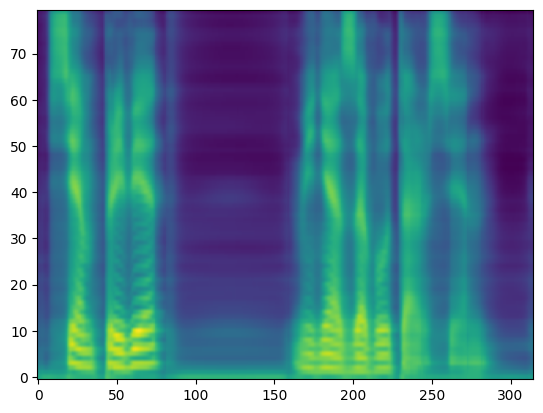

In [30]:
%matplotlib inline
plt.imshow(mel[0].detach().cpu().numpy(), origin="lower", aspect="auto")
plt.show()